In [ ]:
using Pkg             # Load the package manager

# ONLY RUN THIS IF YOU HAVE DIFFERENT VERSIONS OF THE PACKAGES BELOW INSTALLED
# This creates a new environment in the current working directory
#
# Pkg.activate(".")

# Install the packages we need
Pkg.add([ "Catalyst", "DifferentialEquations", "Plots", "Random", "Distributions" ])

   Resolving package versions...
  No Changes to `~/Documents/Code/clone-wars/Project.toml`
  No Changes to `~/Documents/Code/clone-wars/Manifest.toml`
Precompiling project...
    411.7 ms  ✓ mtdev_jll
    340.8 ms  ✓ libevdev_jll
    340.3 ms  ✓ Xorg_xcb_util_jll
    343.9 ms  ✓ gperf_jll
    297.8 ms  ✓ libdecor_jll
    264.3 ms  ✓ eudev_jll
    252.2 ms  ✓ Qt6Wayland_jll
  7 dependencies successfully precompiled in 2 seconds. 499 already precompiled.


In [2]:
using Catalyst

In [ ]:
# Initial set up using Catalyst.jl
# Two state model for demonstrative purposes
rn = @reaction_network begin
    μ_S, S --> 0        # stem cell death 
    μ_D, D --> 0        # differentiated cell death 
    σ, S --> 2*S        # stem cell division
    λ, S --> D          # differentiation 
    2*σ/K, 2*S --> S    # incorporating carrying capacity
end

Model ##ReactionSystem#247:
Unknowns (2): see unknowns(##ReactionSystem#247)
  S(t)
  D(t)
Parameters (5): see parameters(##ReactionSystem#247)
  μ_S
  μ_D
  σ
  λ
  ⋮

In [4]:
osys = convert(ODESystem, rn)

Model ##ReactionSystem#235:
Equations (2):
  2 standard: see equations(##ReactionSystem#235)
Unknowns (2): see unknowns(##ReactionSystem#235)
  S(t)
  D(t)
Parameters (5): see parameters(##ReactionSystem#235)
  μ_S
  μ_D
  σ
  λ
  ⋮

In [ ]:
# Model parameters and values
p = [ :μ_S => 0.1, 
      :μ_D => 0.2,
      :σ => 0.3,
      :λ => 0.15,
      :K => 100 ]

# Initial conditions
u0 = [ :S => 1, :D => 0 ]

# Simulation length
tmax = 100.0;

In [ ]:
# Solve the corresponding ODEs (okay for large numbers of cells)
using DifferentialEquations

prob = ODEProblem(rn, u0, (0, tmax), p)
sol = solve(prob);

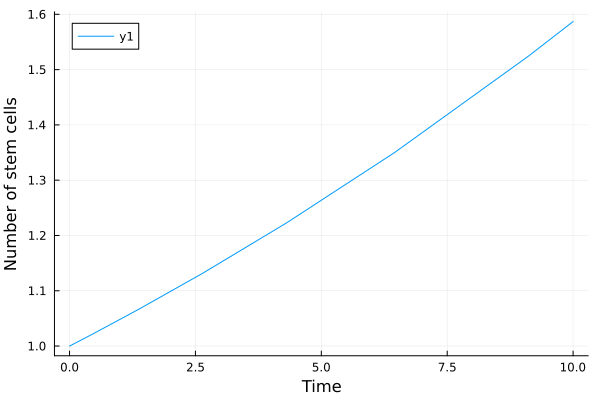

In [21]:
using Plots

plot(sol.t, sol[:S], 
     xlabel="Time", 
     ylabel="Number of stem cells")

In [ ]:
# Set up the stochastic version of the problem and solve for one instance
jinp = JumpInputs(rn, u0, (0, tmax), p)
prob = JumpProblem(jinp);
sol = solve(prob);

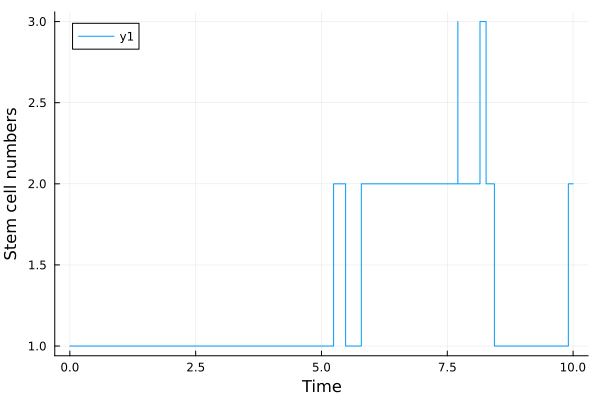

In [24]:
plt = plot(sol.t, sol[:S], 
           xlabel="Time", 
           ylabel="Stem cell numbers", 
           linetype=:steppost)

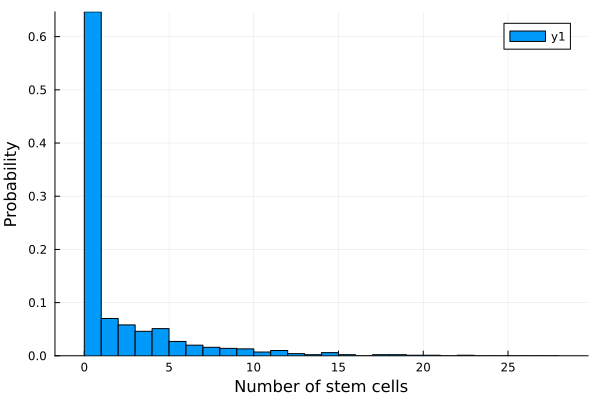

In [26]:
# Array to store the result of each simulation
ns = []
# Number of simulations to perform
n_trajectories = 1000

for i in 1:n_trajectories
    sol = solve(prob)
    s = sol(tmax, idxs=:S) # record the number of stem cells at time t = tmax
    push!(ns, s)
end

# Compute and plot the discrete probability distribution
histogram(ns, 
          bins=0:maximum(ns), # define bins from 0 to the maximum observed number of stem cells
          normalize=:probability,
          xlabel="Number of stem cells", 
          ylabel="Probability") 